# Rakuten USA - Data Engineering Test

### Goal
The goal of this test is not ment to be exhaustive, but we do want to test your skills in analytical thinking, SQL, data wrangling, data analysis, and data visualization.

### Expectations
You can expect this test to use the following technologies:
- Python3
- Jupyter Notebook
- PySpark
- PySpark SQL

This test will cover the following areas: 
- Data cleaning/wrangling
- Exploratory Data Analysis (EDA)
- Data Visualization 

This test should take you no more than 2-4 hours.

### What to turn in, and where to send your test
Please email stirling.waite@rakuten with your finished notebook
- rakuten_engineering_test.ipynb
 
### Questions?
Feel free to email me or call me with any questions about this test
- stirling.waite@rakuten.com
- 801-856-1426

# About The Dataset

Below you will find a modified free Kaggle competition dataset from https://www.kaggle.com/mayank811/employee-reviews/data using scraped data from Glassdoor.com.

## Context
- Over 67k employee reviews for Google, Amazon, Facebook, Apple, Microsoft, and Netflix.
- Web scraped from Glassdoor

## Content
This dataset contains employee reviews separated into the following categories:

- **Index:** index
- **Company:** Company name
- **Location:** This dataset is global, as such it may include the country's name in parenthesis [i.e "Toronto, ON(Canada)"]. However, if the location is in the USA then it will only include the city and state[i.e "Los Angeles, CA" ]
- **Date Posted:** in the following format MM DD, YYYY
- **Job-Title:** This string will also include whether the reviewer is a 'Current' or 'Former' Employee at the time of the review
- **Summary:** Short summary of employee review
- **Pros:** Pros
- **Cons:** Cons
- **Overall Rating:** 1-5
- **Work/Life Balance Rating:** 1-5
- **Culture and Values Rating:** 1-5
- **Career Opportunities Rating:** 1-5
- **Comp & Benefits Rating:** 1-5
- **Senior Management Rating:** 1-5
- **Helpful Review Count:** 1-5

**Link to Review:** This will provide you with a direct link to the page that contains the review. However it is likely that this link will be outdated

**NOTE:** 'none' is placed in all cells where no data value was found.



# PySpark Initialization

In [1]:
import re
import pyspark
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import *
from pyspark.sql import functions as fn
from pyspark.sql import types as t
from pyspark.sql.types import *
from datetime import datetime

In [2]:
conf = SparkConf()\
                .setMaster("local[*]")\
                .setAppName("rakutenHomework")
conf.set("spark.executor.heartbeatInterval","100s")
sc = SparkContext(conf=conf)
sc.setLogLevel("ERROR")
sqlContext = SQLContext(sc)
spark = SparkSession.builder.appName("spark play").getOrCreate()

In [3]:
#spark.stop()

## Read Dataset into Spark

In [4]:
# Read the csv file
reviews_df = spark.read.csv("employee_reviews_usa.csv", header=True, mode="DROPMALFORMED", inferSchema='true', encoding="utf-8")
print(reviews_df.count())
reviews_df.show()

28357
+---+-------+-----------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+--------------------+
|_c0|company|         location|        dates|           job_title|             summary|                pros|                cons|      advice_to_mgmt|overall_ratings|work_balance_stars|culture_values_stars|carrer_opportunities_stars|comp_benefit_stars|senior_mangemnet_stars|helpful_count|                link|
+---+-------+-----------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+--------------------+
|  0| google|Mountain View, CA|  Feb 8, 2015|Current Employee

In [5]:
# Printing the schema
reviews_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- company: string (nullable = true)
 |-- location: string (nullable = true)
 |-- dates: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- pros: string (nullable = true)
 |-- cons: string (nullable = true)
 |-- advice_to_mgmt: string (nullable = true)
 |-- overall_ratings: string (nullable = true)
 |-- work_balance_stars: string (nullable = true)
 |-- culture_values_stars: string (nullable = true)
 |-- carrer_opportunities_stars: string (nullable = true)
 |-- comp_benefit_stars: string (nullable = true)
 |-- senior_mangemnet_stars: string (nullable = true)
 |-- helpful_count: string (nullable = true)
 |-- link: string (nullable = true)



# Data Cleaning & Removing Un-Needed Columns

No one likes dirty data.  Let's clean up this dataset to make it more usable for our use case.

 
1. Make the date field more data friendly
    - Hint #1: Use the provided `review_date_udf` udf provided (it will make your life more simple) 
2. Using the "location" column 
    - Add new columns for city, state, country columns
        - Hint #1: Concider using `fn.split()` to split `location` for columns `city` `state` 
        - Hint #2: I've narrowed down the country to just US, so please use something like below to create the `country` column
            - ```lit("US").alias("country")```
3. Using the "job-title" column  
    - Add a new boolean column titled "current_employee" that will show:
        - 1,  if reviewer is a current employee
        - 0,  if reviewer is not a current employee
        - Hint:  Use spark function `fn.when()` and `col("job-title").contains("")`
    - Remove "Former Employee - " and "" from the "job-title" column
        - Hint: Use the udf function `reg_job_title_udf`
4. Drop un-needed columns 
    - "_c0", "link", "pros", "cons", "advice-to-mgmt", "summary", "location"

In [6]:
# 1 convert all the string columns to Double numbers
reviews_df = reviews_df.withColumn('overall_ratings', reviews_df["overall_ratings"].cast(DecimalType()))
reviews_df = reviews_df.withColumn('work_balance_rating', reviews_df["work_balance_stars"].cast(DecimalType()))
reviews_df = reviews_df.withColumn('culture_values_stars', reviews_df["culture_values_stars"].cast(DecimalType()))
reviews_df = reviews_df.withColumn('carrer_opportunities_stars', reviews_df["carrer_opportunities_stars"].cast(DecimalType()))
reviews_df = reviews_df.withColumn('comp_benefit_stars', reviews_df["comp_benefit_stars"].cast(DecimalType()))
reviews_df = reviews_df.withColumn('senior_mangemnet_stars', reviews_df["senior_mangemnet_stars"].cast(DecimalType()))

In [7]:
# 2 Split location column into 3 columns - city,state and country

# Split and provide values
split_col = pyspark.sql.functions.split(reviews_df['location'], ',')
reviews_df = reviews_df.withColumn('city', split_col.getItem(0))
reviews_df = reviews_df.withColumn('state', split_col.getItem(1))

# constatnt literal
reviews_df = reviews_df.withColumn('country', fn.lit('US'))

In [8]:
# 3 Splitting the job_title into different columns and adding the current_employee column

# Split and assign current_employee 
split_col = pyspark.sql.functions.split(reviews_df['job_title'], '-')
reviews_df = reviews_df.withColumn('job_title_emp', split_col.getItem(0))
reviews_df= reviews_df.withColumn('current_employee', fn.when(reviews_df.job_title_emp.like("%Current Employee%"),1).otherwise(0))

# Remove unwanted data from job_title
reviews_df = reviews_df.withColumn('job_title', split_col.getItem(1))


In [9]:
# 4 Removing the unwanted columns
reviews_df = reviews_df.drop("_c0", "link", "pros", "cons", "advice-to-mgmt", "summary", "location",'job_title_emp')

In [10]:
reviews_df.show(2)

+-------+------------+-------------------+--------------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+-------------------+-------------+-----+-------+----------------+
|company|       dates|          job_title|      advice_to_mgmt|overall_ratings|work_balance_stars|culture_values_stars|carrer_opportunities_stars|comp_benefit_stars|senior_mangemnet_stars|helpful_count|work_balance_rating|         city|state|country|current_employee|
+-------+------------+-------------------+--------------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+-------------------+-------------+-----+-------+----------------+
| google| Feb 8, 2015| Anonymous Employee|Keep on NOT micro...|              5|               2.0|                   5|                         5|                 4|                     5|        

In [11]:
# The conversion for the Date collumn did not happen. It was throwing errors continuosly. I tried in other system, I am not sure this issue is due to my machine only. 
# Hence after converting to pandas dataframe I have mentioned the conversion there

In [12]:
reviews_df.columns

['company',
 'dates',
 'job_title',
 'advice_to_mgmt',
 'overall_ratings',
 'work_balance_stars',
 'culture_values_stars',
 'carrer_opportunities_stars',
 'comp_benefit_stars',
 'senior_mangemnet_stars',
 'helpful_count',
 'work_balance_rating',
 'city',
 'state',
 'country',
 'current_employee']

# Cleaned Spark Dataframe

- I've included the starting of dataframe, but in the `select` you will want to add the fixes and columns needed to answer the questions below


In [13]:
cleaned_reviews_df = reviews_df.where((col("dates") != 'None') & (col("dates") != ' Jan 0, 0000') & (col("dates") != ' Jan 0, 0000') & (col("company") != 'none') & (~col("location").contains("(")) & (col("location") != "none")) \
                         .select('company','dates','job_title','advice_to_mgmt','overall_ratings','work_balance_stars',
'culture_values_stars','carrer_opportunities_stars','comp_benefit_stars','senior_mangemnet_stars','helpful_count',
 'city','state','country','current_employee'
                         )


In [14]:
cleaned_reviews_df.show()

+-------+-------------+--------------------+--------------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+-------------+-----+-------+----------------+
|company|        dates|           job_title|      advice_to_mgmt|overall_ratings|work_balance_stars|culture_values_stars|carrer_opportunities_stars|comp_benefit_stars|senior_mangemnet_stars|helpful_count|         city|state|country|current_employee|
+-------+-------------+--------------------+--------------------+---------------+------------------+--------------------+--------------------------+------------------+----------------------+-------------+-------------+-----+-------+----------------+
| google|  Feb 8, 2015|  Anonymous Employee|Keep on NOT micro...|              5|               2.0|                   5|                         5|                 4|                     5|          498|Mountain View|   CA|     US|               1|


# Data Questions

Each question below will have two parts.   Please solve each problem in PySpark and PySpark SQL.  This is to test your ability to solve the problem in PySpark, and to test your ability to solve the problem in SQL.

- PySpark API (https://spark.apache.org/docs/latest/api/python/index.html)
- PySpark SQL API (https://spark.apache.org/docs/latest/api/python/pyspark.sql.html)

In [15]:
cleaned_reviews_df.createOrReplaceTempView("reviews")

### (1) What is the total number of reviews in the data set?

##### PySpark Implmentation

In [16]:
cleaned_reviews_df.count()

28357

##### Spark SQL Implmentation

In [17]:
spark.sql("SELECT count(*) as review_count FROM reviews").show() # 27779

+------------+
|review_count|
+------------+
|       28357|
+------------+



###  (2) How many reviews exist in the dataset per each company?

##### PySpark Implmentation

In [18]:
cleaned_reviews_df.groupBy('company').count().show()

+---------+-----+
|  company|count|
+---------+-----+
|microsoft| 8114|
|   amazon|10164|
|  netflix|  458|
|    apple| 5853|
| facebook| 1167|
|   google| 2601|
+---------+-----+



##### Spark SQL Implmentation

In [19]:
spark.sql("SELECT count(*) AS count_per_company,company AS review_count FROM reviews GROUP BY company").show()

+-----------------+------------+
|count_per_company|review_count|
+-----------------+------------+
|             8114|   microsoft|
|            10164|      amazon|
|              458|     netflix|
|             5853|       apple|
|             1167|    facebook|
|             2601|      google|
+-----------------+------------+



###  (3) How many reviews are from former and current employees per each company?

##### PySpark Implmentation

In [20]:
cleaned_reviews_df.groupBy('current_employee','company').count().show()

+----------------+---------+-----+
|current_employee|  company|count|
+----------------+---------+-----+
|               1|   amazon| 6753|
|               0|   google|  946|
|               0|   amazon| 3411|
|               1|    apple| 3408|
|               0|microsoft| 2865|
|               1|   google| 1655|
|               1|microsoft| 5249|
|               0|    apple| 2445|
|               0|  netflix|  223|
|               1|  netflix|  235|
|               1| facebook|  945|
|               0| facebook|  222|
+----------------+---------+-----+



##### Spark SQL Implmentation

In [21]:
spark.sql("SELECT count(*) AS count_reviews,current_employee,company FROM reviews GROUP BY current_employee,company").show()

+-------------+----------------+---------+
|count_reviews|current_employee|  company|
+-------------+----------------+---------+
|         6753|               1|   amazon|
|          946|               0|   google|
|         3411|               0|   amazon|
|         3408|               1|    apple|
|         2865|               0|microsoft|
|         1655|               1|   google|
|         5249|               1|microsoft|
|         2445|               0|    apple|
|          223|               0|  netflix|
|          235|               1|  netflix|
|          945|               1| facebook|
|          222|               0| facebook|
+-------------+----------------+---------+



###  (4) What is the average review scores of each current and former employees for each company?

##### PySpark Implmentation

In [22]:
cleaned_reviews_df.groupBy('current_employee','company').avg('overall_ratings').show()

+----------------+---------+--------------------+
|current_employee|  company|avg(overall_ratings)|
+----------------+---------+--------------------+
|               1|   amazon|              3.7118|
|               0|   google|              4.1555|
|               0|   amazon|              2.9814|
|               1|    apple|              4.0773|
|               0|microsoft|              3.5613|
|               1|   google|              4.4309|
|               1|microsoft|              3.8620|
|               0|    apple|              3.8300|
|               0|  netflix|              2.9439|
|               1|  netflix|              3.9652|
|               1| facebook|              4.7035|
|               0| facebook|              3.9263|
+----------------+---------+--------------------+



##### Spark SQL Implmentation

In [23]:
spark.sql("SELECT AVG(overall_ratings) AS avg_score,current_employee,company FROM reviews GROUP BY current_employee,company ORDER BY company").show()

+---------+----------------+---------+
|avg_score|current_employee|  company|
+---------+----------------+---------+
|   3.7118|               1|   amazon|
|   2.9814|               0|   amazon|
|   3.8300|               0|    apple|
|   4.0773|               1|    apple|
|   4.7035|               1| facebook|
|   3.9263|               0| facebook|
|   4.4309|               1|   google|
|   4.1555|               0|   google|
|   3.8620|               1|microsoft|
|   3.5613|               0|microsoft|
|   3.9652|               1|  netflix|
|   2.9439|               0|  netflix|
+---------+----------------+---------+



###  (5) Show the count of former Google employee reviews and the average work_balance_score in locations Seattle, San Francisco, or Utah
- Please show in one solution  

##### PySpark Implmentation

In [24]:
cleaned_reviews_df.where(col('company').isin('google') & col('current_employee').isin(0) & col("city").isin({'Seattle','San Francisco','Utah'})).groupBy("city").agg(avg('work_balance_stars'),count('city')).show()

+-------------+-----------------------+-----------+
|         city|avg(work_balance_stars)|count(city)|
+-------------+-----------------------+-----------+
|San Francisco|      4.340579710144928|         72|
|      Seattle|     3.5294117647058822|         19|
+-------------+-----------------------+-----------+



##### Spark SQL Implmentation

In [25]:
spark.sql("SELECT COUNT(*) as count, AVG(work_balance_stars) AS score,city FROM reviews WHERE company = 'google' AND current_employee =0 AND city IN ('Seattle','San Francisco','Utah') GROUP BY city").show()

+-----+------------------+-------------+
|count|             score|         city|
+-----+------------------+-------------+
|   72| 4.340579710144928|San Francisco|
|   19|3.5294117647058822|      Seattle|
+-----+------------------+-------------+



# Data Visualization
1. Turn your Spark dataframe into a Pandas dataframe
    - https://pandas.pydata.org/
2. Answer the visualization questions with any of the following libraries:
    - Matplotlib (https://matplotlib.org/)
    - Seaborn (https://seaborn.pydata.org/introduction.html)
    - Bookeh (https://bokeh.pydata.org/en/latest/)

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

In [27]:
# Conversions are done here
reviews_pd_df = cleaned_reviews_df.toPandas()
reviews_pd_df.replace('None',0)
reviews_pd_df['dates'] = pd.to_datetime(reviews_pd_df['dates'], format=' %b %d, %Y')

In [28]:
reviews_pd_df = reviews_pd_df.fillna(0)

In [29]:
print(reviews_pd_df)

         company      dates                                      job_title  \
0         google 2015-02-08                             Anonymous Employee   
1         google 2018-12-09                                           SDE2   
2         google 2018-12-11                              Software Engineer   
3         google 2018-12-10                             Anonymous Employee   
4         google 2018-12-08                             Anonymous Employee   
5         google 2018-12-03                       Sales Operations Analyst   
6         google 2018-11-26                                       Designer   
7         google 2018-11-29                               Staff Accountant   
8         google 2018-11-17                              Program Manager I   
9         google 2018-12-09                                Senior Director   
10        google 2018-12-08                   Software Engineering Manager   
11        google 2018-11-20                              Google 

### Plot the distribution of reviewers who are current and former employees
- Hint: A Seaborn factorplot will work nicely here
    - https://kite.com/python/docs/seaborn.factorplot
    

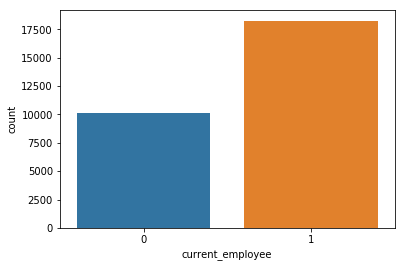

In [30]:
# Count of current and former employee reviewers 
sns.countplot(data = reviews_pd_df , x='current_employee')

### Plot the distributions of reviews for each company (current and former employees) and their overall ratings
- Hint: A Seaborn factorplot will work nicely here
    - https://kite.com/python/docs/seaborn.factorplot

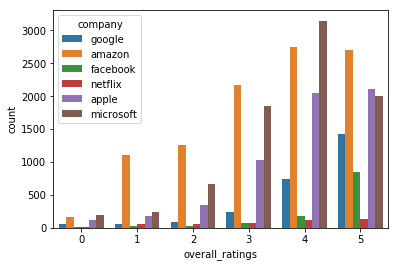

In [31]:
# Distribution of rating for each company
sns.countplot(data = reviews_pd_df , x='overall_ratings',hue='company')